In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.optim import Adam
from matplotlib import pyplot as plt
from utils import get_mnist_data, get_device
from models import ConvNN
from training_and_evaluation import train_model, predict_model
from attacks import gradient_attack
from torch.nn.functional import cross_entropy
from typing import Tuple

# Project 2, part 2: Adversarial training (20 pt)
In this notebook we perform adversarial training on the convolutional neural network from Part 1.

## Your task
Complete the missing code in this notebook. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Specifically, for this part you will have to implement the following functions / classes:  

**This notebook**
* The `loss_function` used for adversarial training. (20pt)

## General remarks

Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

Note that plagiarising even a single project task will make you ineligible for the bonus this semester.

In [2]:
mnist_trainset = get_mnist_data(train=True)
mnist_testset = get_mnist_data(train=False)
device = get_device()

model = ConvNN()
model.to(device)

epochs = 2
batch_size = 128
test_batch_size = 1000  # feel free to change this
lr = 1e-3

opt = Adam(model.parameters(), lr=lr)

attack_args = {'norm': "2", "epsilon": 5}

### Loss function



In [4]:
def loss_function(x: torch.Tensor, y: torch.Tensor, model: torch.nn.Module,  
                  **attack_args) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Loss function used for adversarial training. First computes adversarial 
    examples on the input batch via gradient_attack and then computes the 
    logits and the loss on the adversarial examples.
    Parameters
    ----------
    x: torch.Tensor of shape [B, C, N, N], where B is the batch size, C is the 
       number of channels, and N is the image width/height.
        The input batch to certify.
    y: torch.Tensor of shape [B, 1].
        The labels of the input batch.
    model: torch.nn.Module
        The classifier to be evaluated.
    attack_args: 
        additional arguments passed to the adversarial attack function.
    
    Returns
    -------
    Tuple containing
        * loss_pert: torch.Tensor, scalar
            Mean loss obtained on the adversarial examples.
        * logits_pert: torch.Tensor, shape [B, K], K is the number of classes
            The logits obtained on the adversarial examples.
    """
    ##########################################################
    # YOUR CODE HERE
    #Basically computing loss on the worst case attack obtained by gdm algorithm
    x.requires_grad_()
    out = model(x)
    
    perturbed_x = gradient_attack(out, x, y, **attack_args)
    model.zero_grad()
    logits_pert = model(perturbed_x)
    
    loss_pert = cross_entropy(logits_pert, y)
    ##########################################################
    # Important: don't forget to call model.zero_grad() after creating the 
    #            adversarial examples.
    return loss_pert, logits_pert

In [5]:
losses, accuracies = train_model(model, mnist_trainset, batch_size, device,
                                 loss_function=loss_function, optimizer=opt, 
                                 loss_args=attack_args, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [6]:
torch.save(model.state_dict(), "models/adversarial_training.checkpoint")

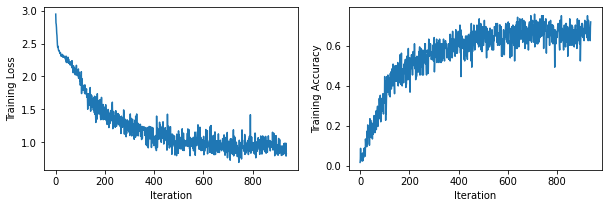

In [7]:
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.plot(accuracies)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.show()

In [8]:
clean_accuracy = predict_model(model, mnist_testset, batch_size, device,
                               attack_function=None)

  0%|          | 0/79 [00:00<?, ?it/s]

In [9]:
perturbed_accuracy = predict_model(model, mnist_testset, test_batch_size, device, 
                                   attack_function=gradient_attack, 
                                   attack_args=attack_args)

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
clean_accuracy

0.9147999882698059

In [11]:
perturbed_accuracy

0.6965000033378601